In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from imblearn import over_sampling

from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, make_scorer, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pip install shap


  Using cached shap-0.42.1-cp39-cp39-win_amd64.whl (462 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_excel('E Commerce Dataset.xlsx')
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


# 1. EDA

In [4]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [5]:
summary('data',df)

data shape: (5630, 20)


,dtypes,null,unique,min,median,max,mean,std
CustomerID,int64,0,5630,50001,52815.50,55630,52815.500000,1625.385339
Churn,int64,0,2,0,0.00,1,0.168384,0.374240
Tenure,float64,264,36,0.0,9.00,61.0,10.189899,8.557241
PreferredLoginDevice,object,0,3,Computer,NaN,Phone,NaN,NaN
CityTier,int64,0,3,1,1.00,3,1.654707,0.915389
WarehouseToHome,float64,251,34,5.0,14.00,127.0,15.639896,8.531475
PreferredPaymentMode,object,0,7,CC,NaN,UPI,NaN,NaN
Gender,object,0,2,Female,NaN,Male,NaN,NaN
HourSpendOnApp,float64,255,6,0.0,3.00,5.0,2.931535,0.721926
NumberOfDeviceRegistered,int64,0,6,1,4.00,6,3.688988,1.023999


In [6]:
cats= ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
ordinal = ['CityTier', 'SatisfactionScore']
binary = ['Churn', 'Complain']
nums = df.loc[:, ~df.columns.isin(cats + binary + ordinal)].columns[1:]

In [7]:
df[cats].describe().T

,count,unique,top,freq
PreferredLoginDevice,5630,3,Mobile Phone,2765
PreferredPaymentMode,5630,7,Debit Card,2314
Gender,5630,2,Male,3384
PreferedOrderCat,5630,6,Laptop & Accessory,2050
MaritalStatus,5630,3,Married,2986


In [8]:
for col in cats:
    vc = df[col].value_counts().rename_axis(col).reset_index(name='Counts')
    display(vc)

,PreferredLoginDevice,Counts
0,Mobile Phone,2765
1,Computer,1634
2,Phone,1231


,PreferredPaymentMode,Counts
0,Debit Card,2314
1,Credit Card,1501
2,E wallet,614
3,UPI,414
4,COD,365
5,CC,273
6,Cash on Delivery,149


,Gender,Counts
0,Male,3384
1,Female,2246


,PreferedOrderCat,Counts
0,Laptop & Accessory,2050
1,Mobile Phone,1271
2,Fashion,826
3,Mobile,809
4,Grocery,410
5,Others,264


,MaritalStatus,Counts
0,Married,2986
1,Single,1796
2,Divorced,848


## Univariate Analysis

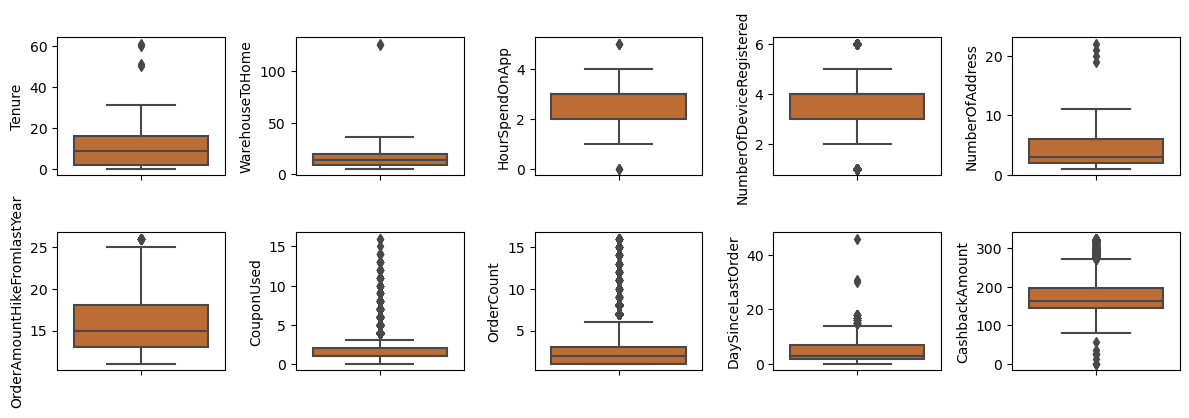

In [9]:
plt.figure(figsize=(12,4))
for i in range(0, len(nums)):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=df[nums[i]], color='chocolate')
    plt.tight_layout()

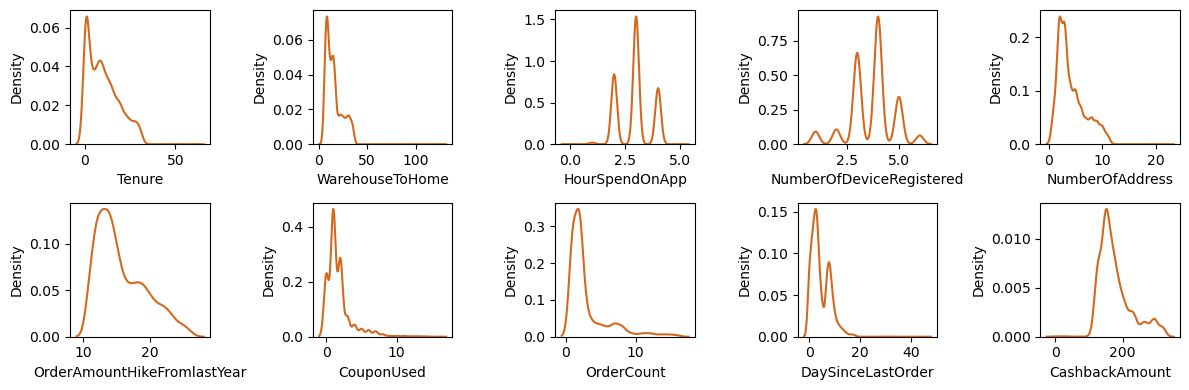

In [10]:
plt.figure(figsize=(12,4))
for i in range(0, len(nums)):
    plt.subplot(2,5,i+1)
    sns.kdeplot(x=df[nums[i]], color='chocolate')
    plt.tight_layout()

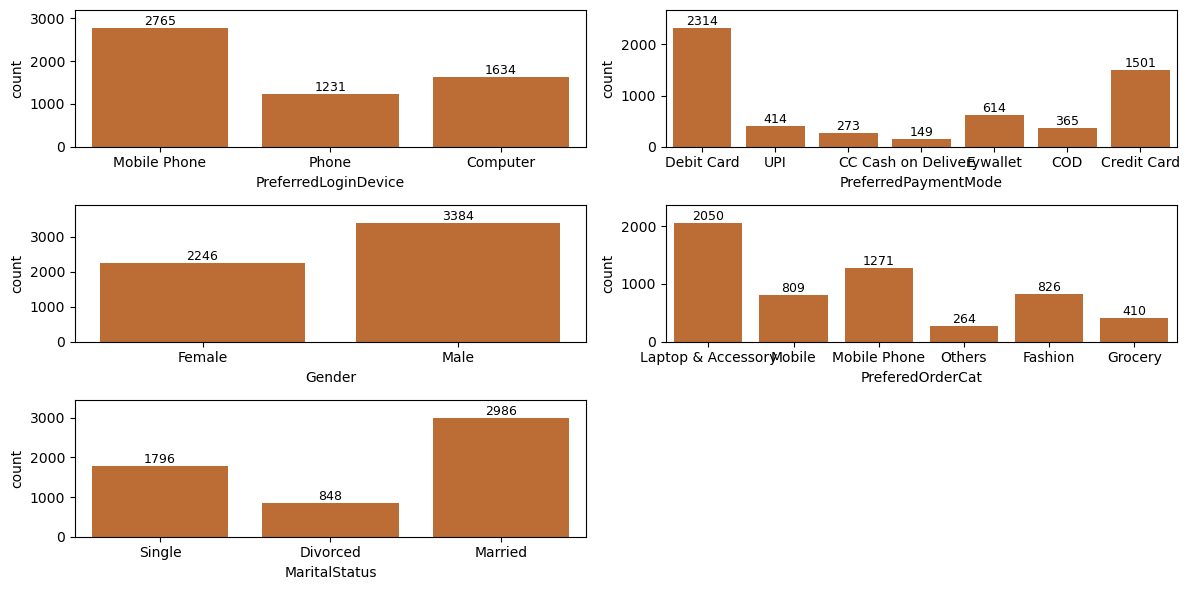

In [11]:
plt.figure(figsize=(12,6))
for i in range(0, len(cats)):
    plt.subplot(3, 2, i+1)
    ax = sns.countplot(x=df[cats[i]], color='chocolate')
    plt.tight_layout()
    for container in ax.containers:
        ax.bar_label(container, fontsize=9, fmt='%.f')
        ax.set_ylim(top = ax.get_ylim()[1]*1.1)

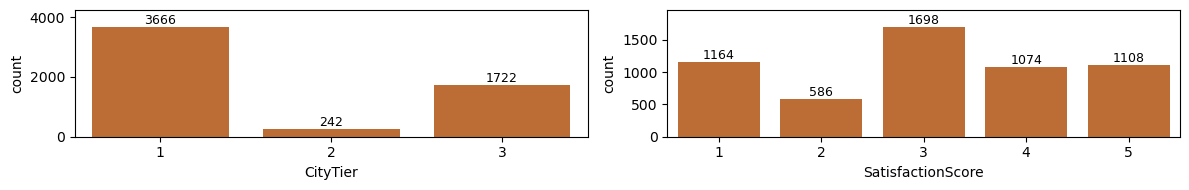

In [12]:
plt.figure(figsize=(12,2))
for i in range(0, len(ordinal)):
    plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=df[ordinal[i]], color='chocolate')
    plt.tight_layout()
    for container in ax.containers:
        ax.bar_label(container, fontsize=9, fmt='%.f')
        ax.set_ylim(top = ax.get_ylim()[1]*1.1)

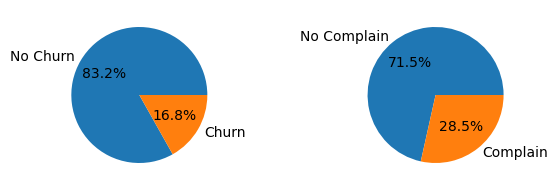

In [13]:
plt.figure(figsize=(12,2))
cats_bin = cats[4:]
for i in range(0, len(binary)):
    plt.subplot(1,4,i+1)
    data=df[binary[i]].value_counts()
    labels = [f'No {binary[i]}', f'{binary[i]}']
    plt.pie(data,labels=labels,autopct='%.1f%%')
    plt.tight_layout()

## Multivariate Analysis

<AxesSubplot:>

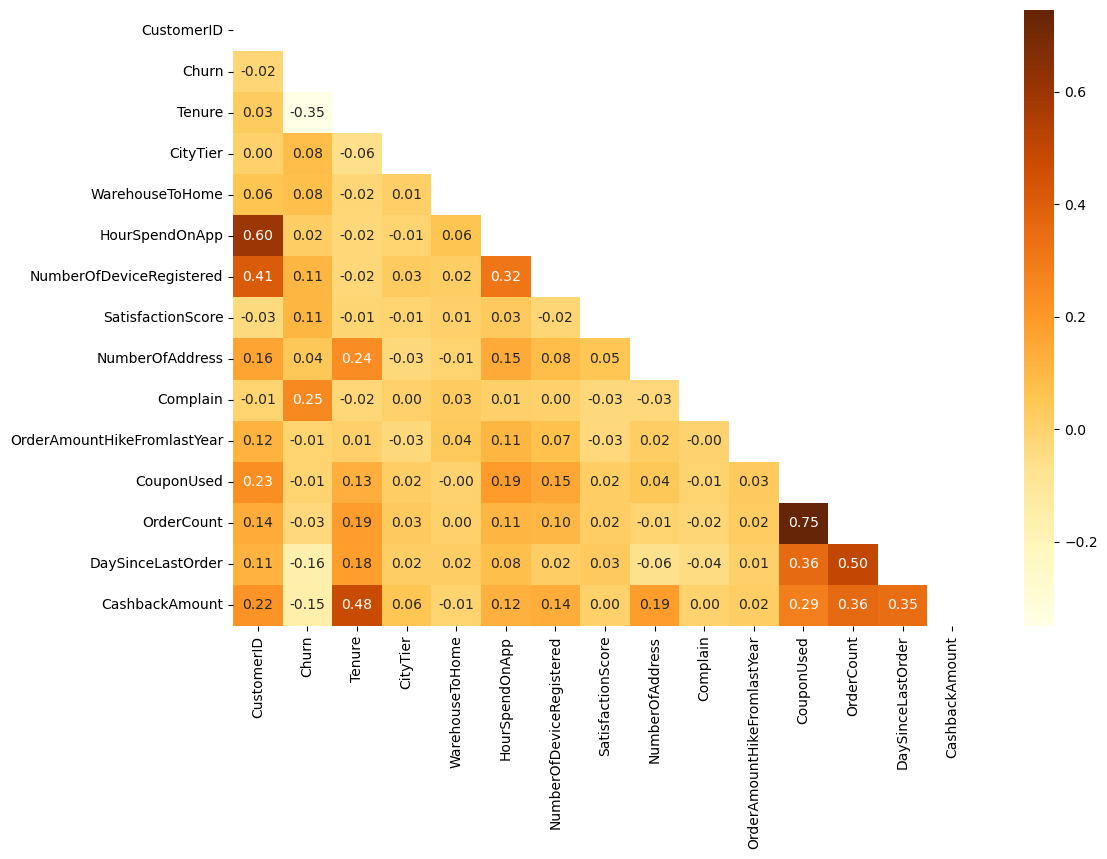

In [14]:
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', cmap='YlOrBr')

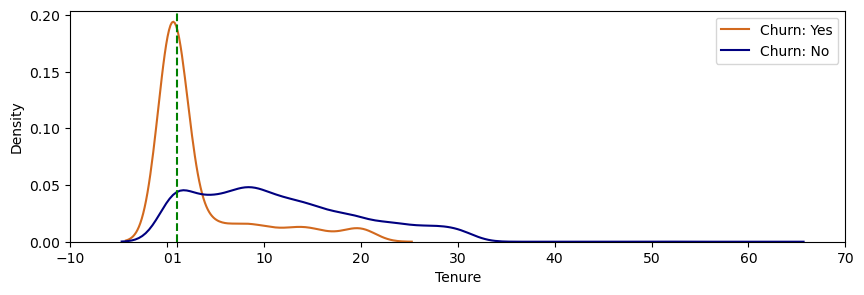

In [15]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.kdeplot(df[df['Churn'] == 1]['Tenure'].dropna(), color= 'chocolate', label= 'Churn: Yes', ax=ax)
sns.kdeplot(df[df['Churn'] == 0]['Tenure'].dropna(), color= 'navy', label= 'Churn: No', ax=ax)
plt.axvline(x=1, ls='--', color='green')
x_ticks = np.append(ax.get_xticks(), 1)
ax.set_xticks(x_ticks)
plt.legend(loc = 1)

In [16]:
def churn_plot(x, data):
    df_cats = data.copy()
    df_city = df_cats.groupby(x)['CustomerID'].nunique().reset_index(name='Total')
    df_churn =  df_cats.groupby([x, 'Churn'])['CustomerID'].nunique().reset_index(name='TotalCustomer')
    df_merge = df_churn.merge(df_city, on=x)
    df_merge['Percentage'] = round(df_merge['TotalCustomer']/df_merge['Total']*100,2)
    
    return df_merge

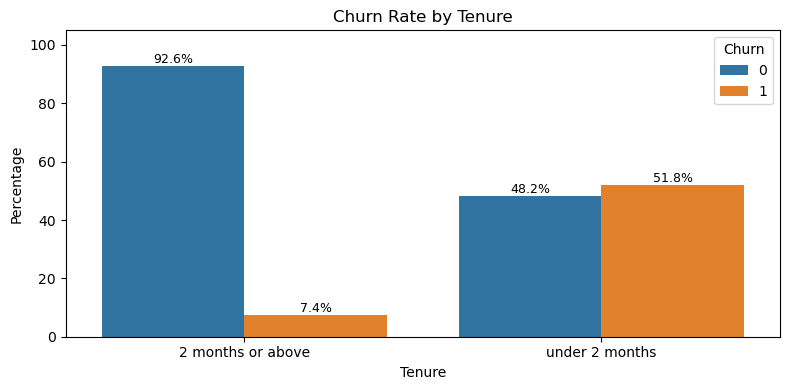

In [17]:
def segment(df):
    if df['Tenure'] < 2:
        return 'under 2 months'
    else:
        return '2 months or above'
        
df_tenure = df.copy()
df_tenure['Tenure'] = df_tenure.apply(lambda x: segment(x), axis=1)

plt.figure(figsize=(8, 4))
data = churn_plot('Tenure', df_tenure)
ax = sns.barplot(x='Tenure', y='Percentage', data=data, hue='Churn')
ax.set_title('Churn Rate by Tenure')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=9)

ax.set_ylim(top=105)
ax.legend(loc=1, title='Churn')
plt.tight_layout()
plt.show()


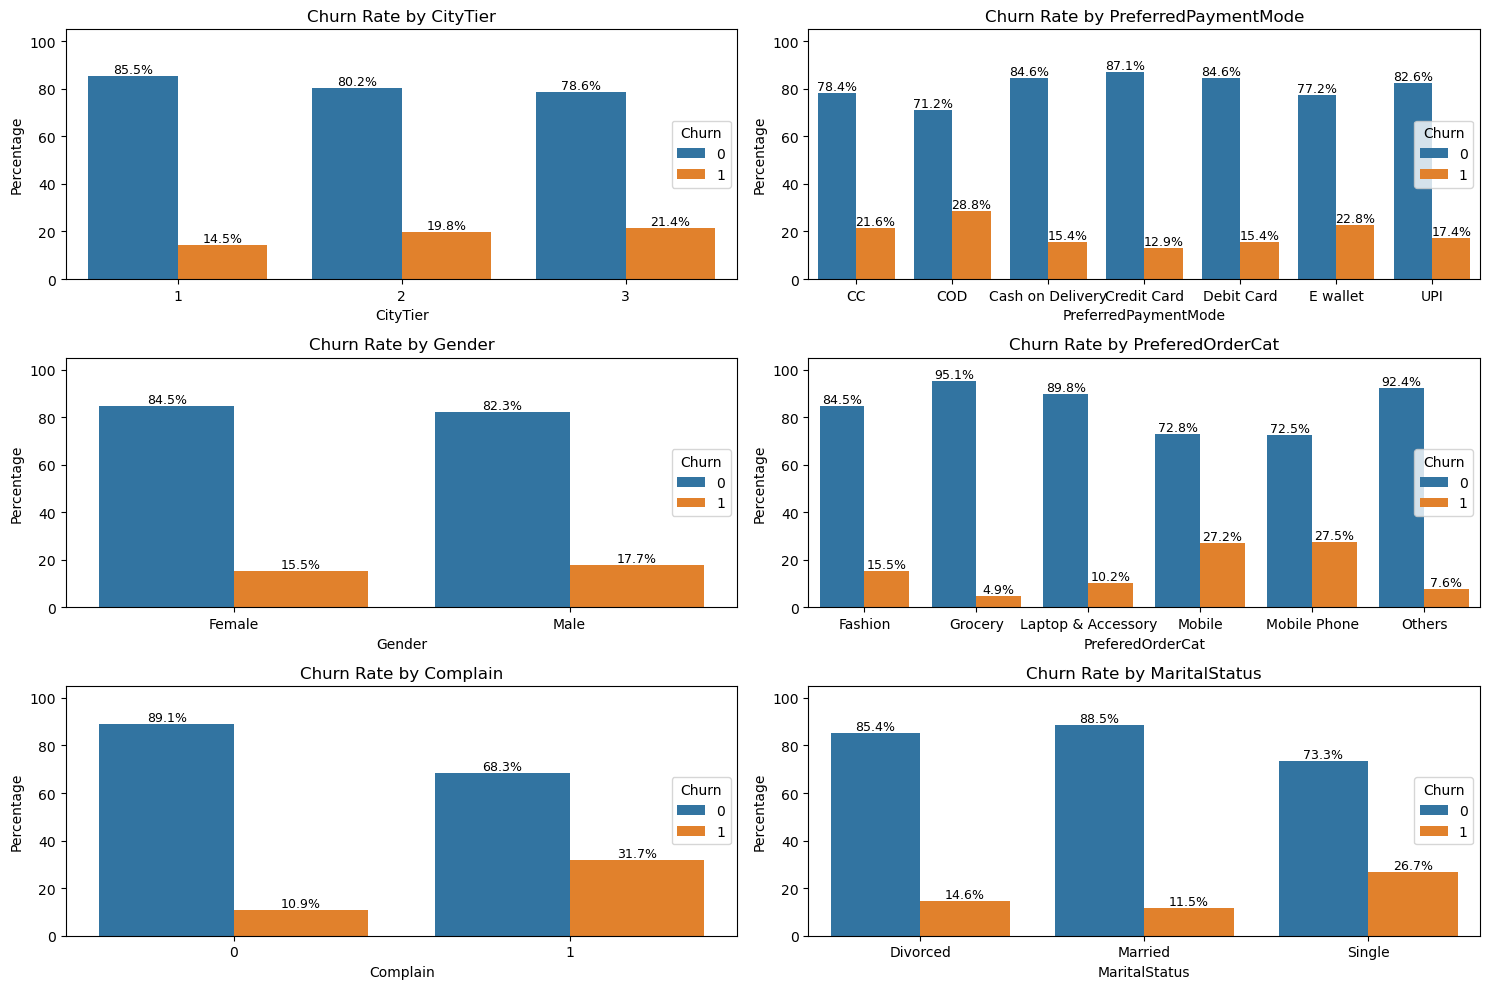

In [18]:
def segment(df):
    if df['Tenure'] < 2:
        return 'under 2 months'
    else:
        return '2 months or above'
        
df_tenure = df.copy()
df_tenure['Tenure'] = df_tenure.apply(lambda x: segment(x), axis=1)

kolom = ['CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'Complain', 'MaritalStatus']

plt.figure(figsize=(15, 10))

for i in range(len(kolom)):
    plt.subplot(3, 2, i + 1)
    data = churn_plot(kolom[i], df)
    ax = sns.barplot(x=kolom[i], y='Percentage', data=data, hue='Churn')
    ax.set_title(f'Churn Rate by {kolom[i]}')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=9)

    ax.set_ylim(top=105)
    ax.legend(loc='center right', title='Churn')

plt.tight_layout()
plt.show()


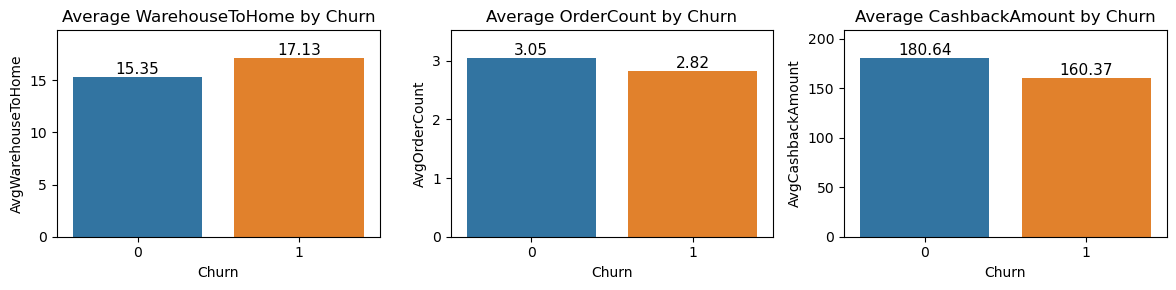

In [19]:
kolom = ['WarehouseToHome', 'OrderCount', 'CashbackAmount']

plt.figure(figsize=(12, 3))

for i in range(len(kolom)):
    plt.subplot(1, 3, i + 1)
    data = df.copy()
    data = data.groupby('Churn')[kolom[i]].mean().reset_index(name='Avg' + kolom[i])
    ax = sns.barplot(x='Churn', y='Avg' + kolom[i], data=data)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
    ax.set_title(f'Average {kolom[i]} by Churn')

plt.tight_layout()
plt.show()


# 2. Preprocessing

## Missing Values

In [20]:
df['Tenure'].fillna(df['Tenure'].median(), inplace=True)
df['WarehouseToHome'].fillna(df['WarehouseToHome'].median(), inplace=True)
df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median(), inplace=True)
df['CouponUsed'].fillna(df['CouponUsed'].median(), inplace=True)
df['OrderCount'].fillna(df['OrderCount'].median(), inplace=True)
df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median(), inplace=True)
df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median(), inplace=True)

## Outliers

In [21]:
print(f'before: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in nums:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    
df = df[filtered_entries]

print(f'after: {len(df)}')

before: 5630
after: 5350


## Duplicated Data

In [22]:
df.duplicated(subset=['CustomerID']).sum()

0

## Feature Encoding

### Label Encoding

In [23]:
df['Gender'] = df['Gender'].replace(['Female','Male'], [0, 1])
df['MaritalStatus'] = df['MaritalStatus'].replace(['Divorced'], ['Single'])
df['MaritalStatus'] = df['MaritalStatus'].replace(['Single','Married'], [0, 1])

### One Hot Encoding

In [24]:
df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace(['Phone','Mobile Phone'], ['Handphone', 'Handphone'])
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace(['CC','COD'], ['Credit Card','Cash on Delivery'])
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace(['Mobile','Mobile Phone', 'Laptop & Accessory'], ['Electronics', 'Electronics', 'Electronics'])

In [25]:
df = pd.get_dummies(df)
df.head()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_Handphone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Electronics,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others
0,50001,1,4.0,3,6.0,0,3.0,3,2,0,9,1,11.0,1.0,1.0,5.0,159.93,0,1,0,0,1,0,0,1,0,0,0
1,50002,1,9.0,1,8.0,1,3.0,4,3,0,7,1,15.0,0.0,1.0,0.0,120.90,0,1,0,0,0,0,1,1,0,0,0
2,50003,1,9.0,1,30.0,1,2.0,4,3,0,6,1,14.0,0.0,1.0,3.0,120.28,0,1,0,0,1,0,0,1,0,0,0
3,50004,1,0.0,3,15.0,1,2.0,4,5,0,8,0,23.0,0.0,1.0,3.0,134.07,0,1,0,0,1,0,0,1,0,0,0
4,50005,1,0.0,1,12.0,1,3.0,3,5,0,3,0,11.0,1.0,1.0,3.0,129.60,0,1,0,1,0,0,0,1,0,0,0


## Feature Engineering

In [26]:
df['AvgCashback'] = df['CashbackAmount'] / df['OrderCount']

### Feature Transformation

In [27]:
column = ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 
          'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 
          'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'AvgCashback']
for col in column:
    df[col] = StandardScaler().fit_transform(df[col].values.reshape(len(df),1))

In [28]:
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_Handphone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,PreferedOrderCat_Electronics,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others,AvgCashback
count,5350.000000,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5.350000e+03,5350.000000,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5.350000e+03,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5.350000e+03
mean,52802.826168,0.170467,1.908287e-16,-1.718252e-17,-1.949271e-16,0.600748,-6.451184e-15,1.253191e-14,-2.521438e-16,0.528037,-1.206205e-15,0.286355,8.073708e-16,6.157421e-15,-6.437218e-16,-1.614544e-15,4.919974e-16,0.289159,0.710841,0.091402,0.315140,0.410280,0.108224,0.074953,0.757570,0.140561,0.062056,0.039813,-3.555826e-17
std,1627.280475,0.376078,1.000093e+00,1.000093e+00,1.000093e+00,0.489791,1.000093e+00,1.000093e+00,1.000093e+00,0.499260,1.000093e+00,0.452100,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,0.453414,0.453414,0.288207,0.464615,0.491931,0.310693,0.263341,0.428593,0.347600,0.241280,0.195538,1.000093e+00
min,50001.000000,0.000000,-1.198863e+00,-7.143355e-01,-1.307003e+00,0.000000,-2.749372e+00,-2.607447e+00,-1.491615e+00,0.000000,-1.256326e+00,0.000000,-1.304506e+00,-1.078464e+00,-7.477119e-01,-1.294154e+00,-2.957067e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.821970e+00
25%,51394.250000,0.000000,-9.542994e-01,-7.143355e-01,-8.110482e-01,0.000000,-1.324620e+00,-6.580561e-01,-7.662794e-01,0.000000,-8.632882e-01,0.000000,-7.448567e-01,-3.699937e-01,-7.477119e-01,-6.825447e-01,-6.284652e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-6.757828e-01
50%,52784.500000,0.000000,-9.832813e-02,-7.143355e-01,-1.911048e-01,1.000000,1.001321e-01,3.166394e-01,-4.094416e-02,1.000000,-4.702500e-01,0.000000,-1.852073e-01,-3.699937e-01,-2.680071e-01,-3.767400e-01,-2.828504e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.799765e-01
75%,54208.750000,0.000000,6.353615e-01,1.474493e+00,5.528273e-01,1.000000,1.001321e-01,3.166394e-01,6.843911e-01,1.000000,7.088646e-01,1.000000,6.542668e-01,3.384767e-01,2.116978e-01,8.464789e-01,3.641027e-01,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.055236e-01
max,55630.000000,1.000000,2.591867e+00,1.474493e+00,2.536646e+00,1.000000,2.949636e+00,2.266030e+00,1.409726e+00,1.000000,2.674056e+00,1.000000,2.892864e+00,3.880828e+00,4.049336e+00,3.292917e+00,3.227246e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.849208e+00


### Feature Selection

<AxesSubplot:>

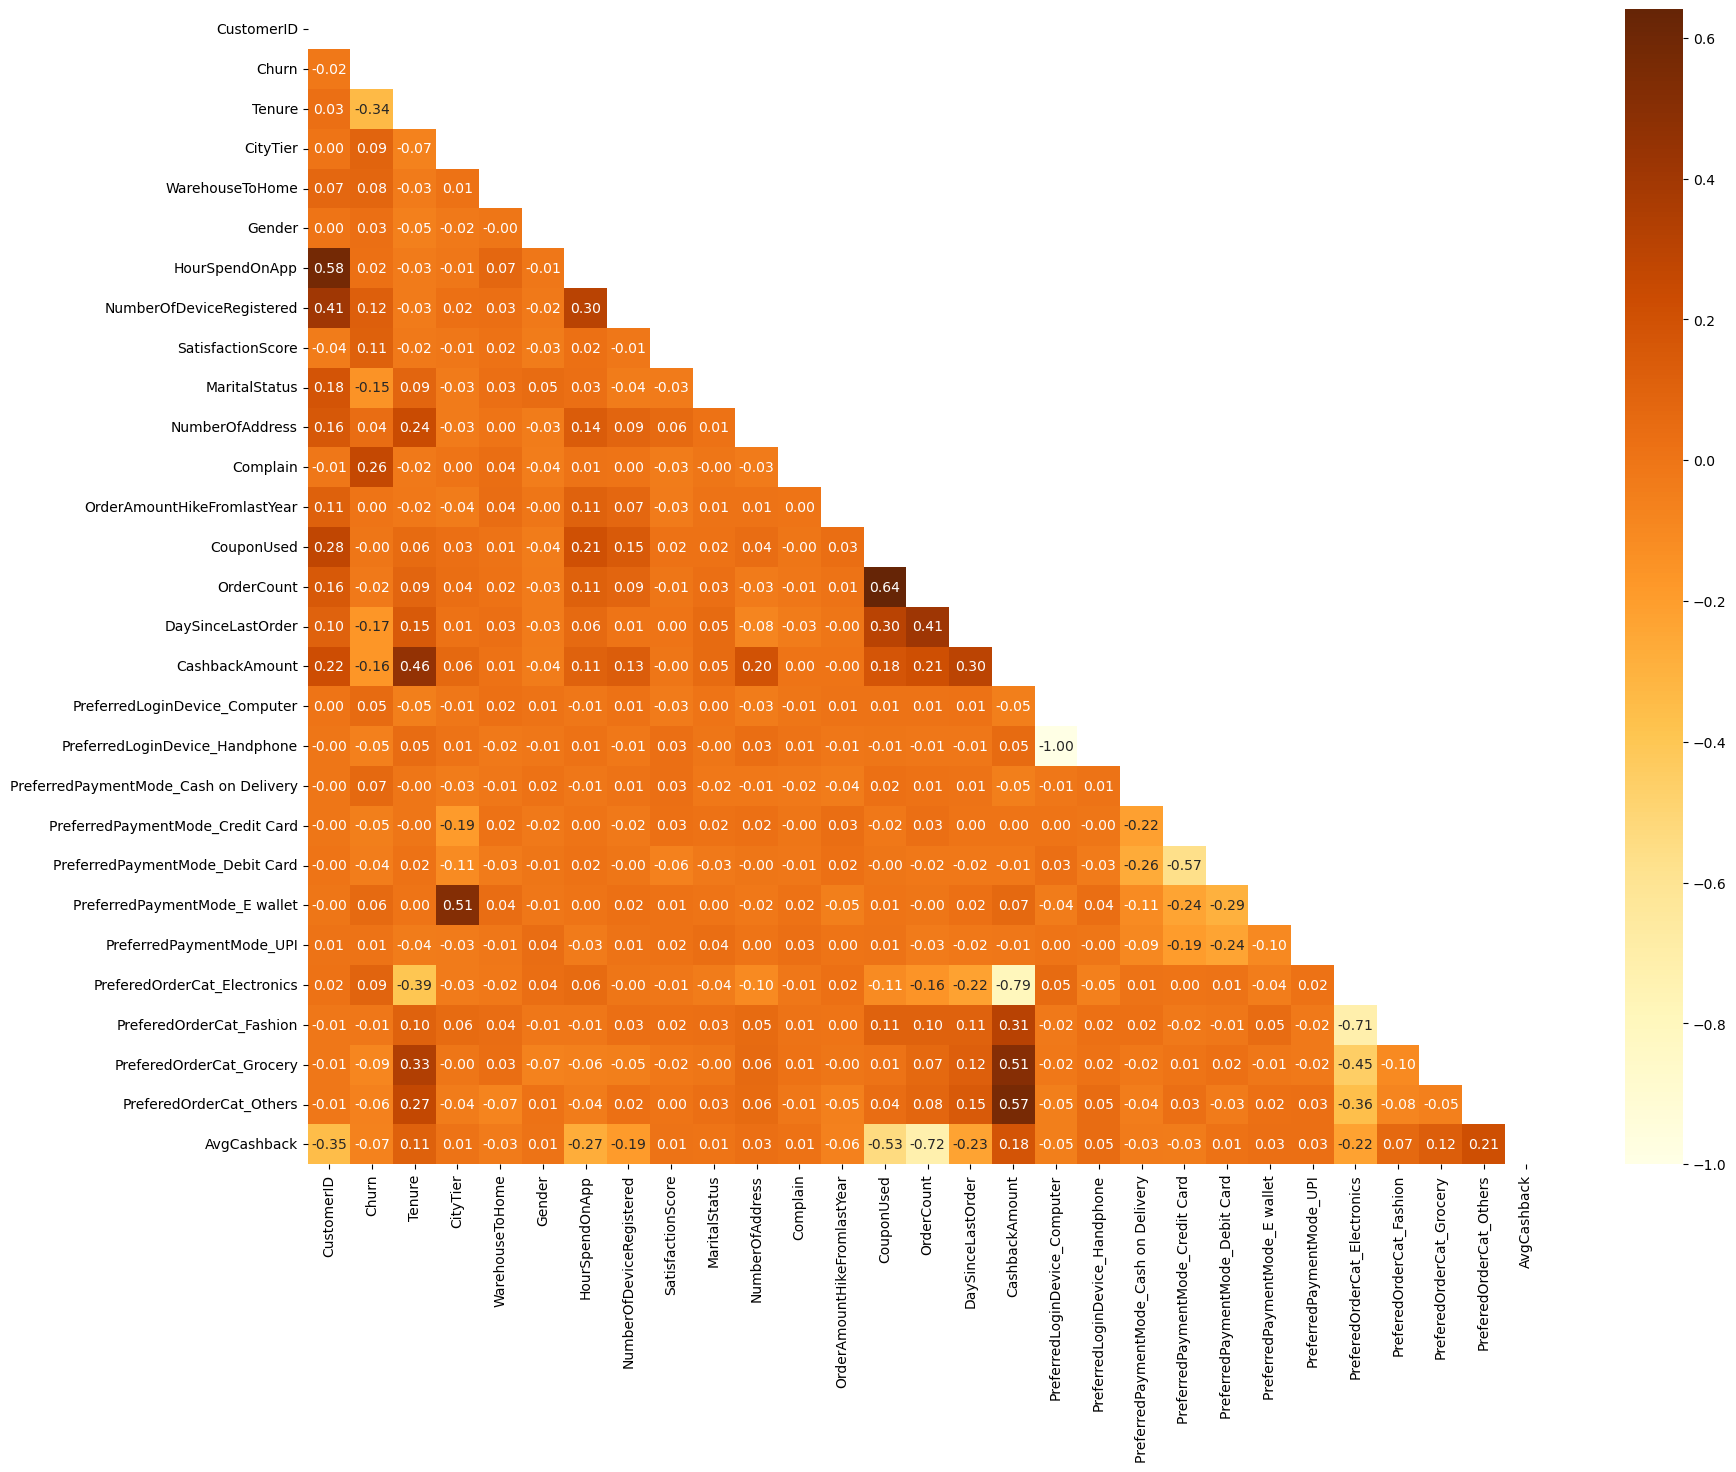

In [29]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', cmap='YlOrBr')

In [30]:
column = []
for col in df.columns:
    if (abs(df['Churn'].corr(df[col])) > 0.05):
        column.append(col)
df_final = df[column]
df_final.sample(3)

,Churn,Tenure,CityTier,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,Complain,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_Handphone,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_E wallet,PreferedOrderCat_Electronics,PreferedOrderCat_Grocery,PreferedOrderCat_Others,AvgCashback
2674,0,-0.954299,0.380079,-0.439082,0.316639,0.684391,1,0,-1.294154,-1.000302,0,1,0,0,1,0,0,0.564696
3058,1,-0.709736,1.474493,1.668725,1.291335,-0.040944,0,1,-0.988349,0.305641,0,1,0,1,1,0,0,-0.083155
4763,0,1.124488,-0.714335,-0.811048,1.291335,-0.040944,0,0,-0.988349,-0.576881,0,1,0,0,1,0,0,-0.478529


## Train Test Split Data

In [31]:
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Handle Class Imbalance

In [33]:
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(4280, 17)
(4280,)
0    3526
1     754
Name: Churn, dtype: int64


In [34]:
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(4280, 17)
(4280,)
0    3526
1     754
Name: Churn, dtype: int64


# 3. Modeling

In [35]:
f2_score = make_scorer(fbeta_score, pos_label=0, beta=2)

In [36]:
def evaluation(model_str, y_pred, y_pred_train):
    results = {
        'model': model_str,
        'acc test' : accuracy_score(y_test, y_pred),
        'acc train': accuracy_score(y_train, y_pred_train),
        'prec test' : precision_score(y_test, y_pred),
        'prec train' : precision_score(y_train, y_pred_train),
        'rec test' : recall_score(y_test, y_pred),
        'rec train' : recall_score(y_train, y_pred_train),
        'f2 test': fbeta_score(y_test, y_pred, pos_label=0,  beta=2),
        'f2 train': fbeta_score(y_train, y_pred_train, pos_label=0,  beta=2)
    }
    return results

In [37]:
model_dict = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Light GBM': LGBMClassifier(),
    'XGBoost': XGBClassifier()
}

In [38]:
%%time
result_list = []
for model in model_dict:
    model_dict[model].fit(X_train, y_train)
    y_pred = model_dict[model].predict(X_test)
    y_pred_train = model_dict[model].predict(X_train)
    result = evaluation(model, y_pred, y_pred_train)
    result_list.append(result)
df_eval = pd.DataFrame(result_list)
df_eval

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 754, number of negative: 3526
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 4280, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176168 -> initscore=-1.542527
[LightGBM] [Info] Start training from score -1.542527
CPU times: total: 2.03 s
Wall time: 1.59 s


,model,acc test,acc train,prec test,prec train,rec test,rec train,f2 test,f2 train
0,Logistic Regression,0.905607,0.874533,0.752212,0.723711,0.537975,0.465517,0.959826,0.947539
1,Decision Tree,0.953271,1.000000,0.821429,1.000000,0.873418,1.000000,0.969231,1.000000
2,Random Forest,0.968224,1.000000,0.892405,1.000000,0.892405,1.000000,0.981360,1.000000
3,AdaBoost,0.917757,0.883879,0.739726,0.722704,0.683544,0.553050,0.955818,0.945134
4,Gradient Boosting,0.916822,0.914019,0.759398,0.845878,0.639241,0.625995,0.959651,0.964883
5,Light GBM,0.964486,0.992056,0.861446,0.986486,0.905063,0.968170,0.976494,0.996373
6,XGBoost,0.968224,1.000000,0.873494,1.000000,0.917722,1.000000,0.978691,1.000000


## Cross Validation

In [39]:
%%time
result_list = {'Model' : [], 'f2 test cv': [], 'f2 train cv': []}
for model in model_dict:
    score = cross_validate(model_dict[model], X, y, cv=5, scoring=f2_score, return_train_score=True)
    ts = score['test_score'].mean()
    tr = score['train_score'].mean()
    result_list['Model'].append(model)
    result_list['f2 test cv'].append(ts)
    result_list['f2 train cv'].append(tr)
df_eval = pd.DataFrame(result_list)
df_eval


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 729, number of negative: 3551
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 4280, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170327 -> initscore=-1.583311
[LightGBM] [Info] Start training from score -1.583311
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 729, number of negative: 3551
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

,Model,f2 test cv,f2 train cv
0,Logistic Regression,0.950057,0.950300
1,Decision Tree,0.989345,1.000000
2,Random Forest,0.991720,1.000000
3,AdaBoost,0.945346,0.949173
4,Gradient Boosting,0.962076,0.966923
5,Light GBM,0.981855,0.996736
6,XGBoost,0.991345,0.999910


## Hyperparameter Tuning

In [40]:
%%time
model = XGBClassifier()

params = {
    'n_estimators' : [99],
    'learning_rate' : [0.27]
}

grid = GridSearchCV(estimator=model, param_grid=params, scoring=f2_score, cv=5)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
y_pred_train = grid.predict(X_train)

result_list = []
result = evaluation('XGBoost', y_pred, y_pred_train)
result_list.append(result)
df_eval = pd.DataFrame(result_list)

print("Best score:", grid.best_score_)
print("Best parameters:", grid.best_params_)
df_eval

Best score: 0.9775459190930107
Best parameters: {'learning_rate': 0.27, 'n_estimators': 99}
CPU times: total: 4.61 s
Wall time: 865 ms


,model,acc test,acc train,prec test,prec train,rec test,rec train,f2 test,f2 train
0,XGBoost,0.971963,0.999533,0.885542,0.998674,0.93038,0.998674,0.980888,0.999716


In [41]:
def draw_learning_curve(param_name, param_values):
    train_scores = []
    test_scores = []

    for value in param_values:
        param = {param_name: value}
        model = XGBClassifier(**param)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train = model.predict(X_train)
        f2_train = fbeta_score(y_train, y_pred_train, pos_label=0,  beta=2)
        train_scores.append(f2_train)

        # eval on test
        y_pred = model.predict(X_test)
        f2_test = fbeta_score(y_test, y_pred, pos_label=0,  beta=2),
        test_scores.append(f2_test)
        
        diff = f2_train - f2_test

        print('param value: ' + str(value) + '; train: ' + str(f2_train) + '; test: '+ str(f2_test)+ '; diff: '+ str(diff))

    fig = plt.plot(param_values, train_scores, label='Train')
    fig = plt.plot(param_values, test_scores, label='Test')
    fig = plt.xlabel('k')
    fig = plt.ylabel('f2')
    fig = plt.title('Learning Curve')
    fig = plt.legend()
    fig = plt.show()
    return fig

# param_name = 'min_child_weight'
# param_values = [int(x) for x in np.linspace(40, 100,num = 31)] 
# param_values = [float(x) for x in np.linspace(0.01, 0.3,num = 30)]
# draw_learning_curve(param_name, param_values) #0.11,0.375

## Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

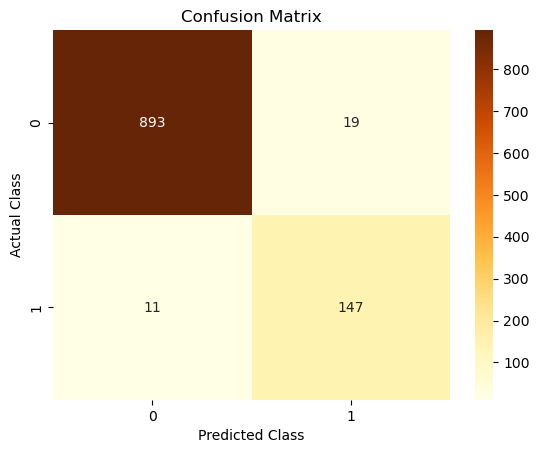

In [42]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix') # 884,28,13,145

## Feature Importance

Text(0.5, 1.0, 'feature importance score')

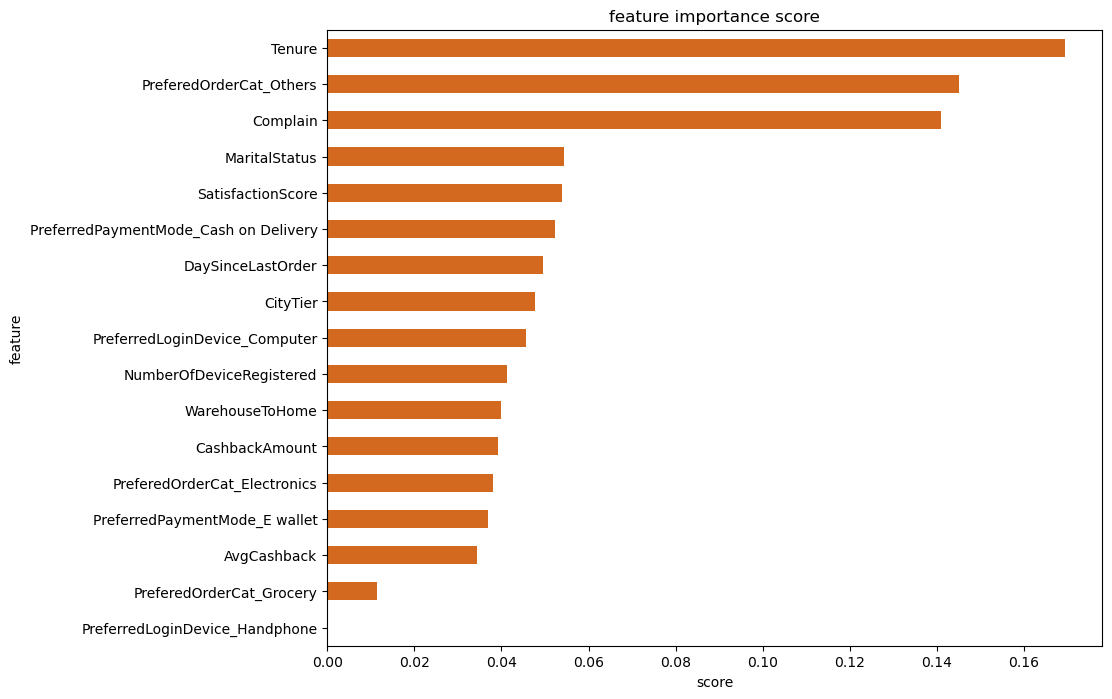

In [43]:
best_model = grid.best_estimator_
feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8), color='chocolate')
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

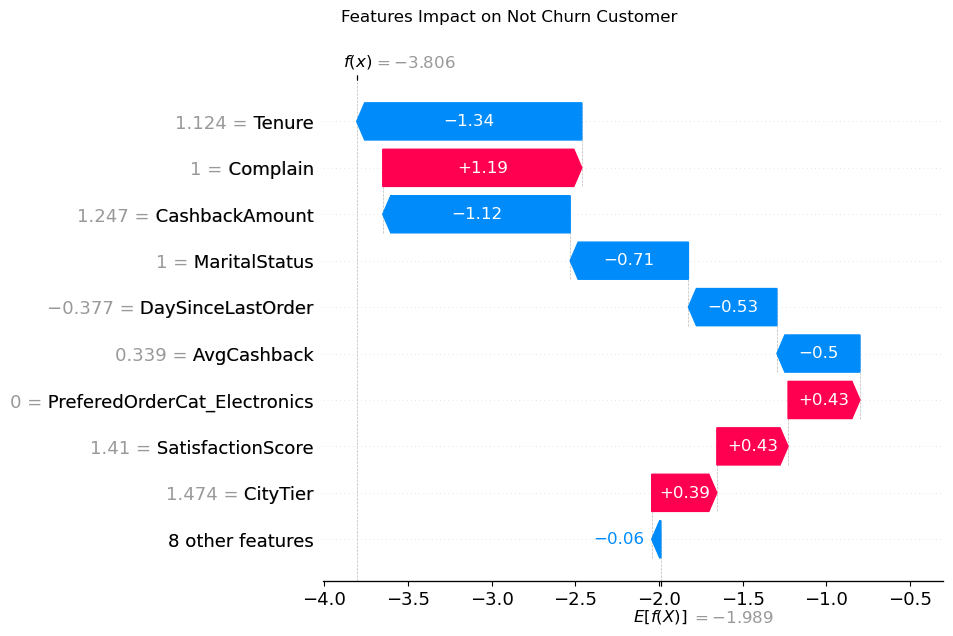

In [44]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0], show=False)
plt.title('Features Impact on Not Churn Customer',x=0.3, y=1.1)
plt.show()

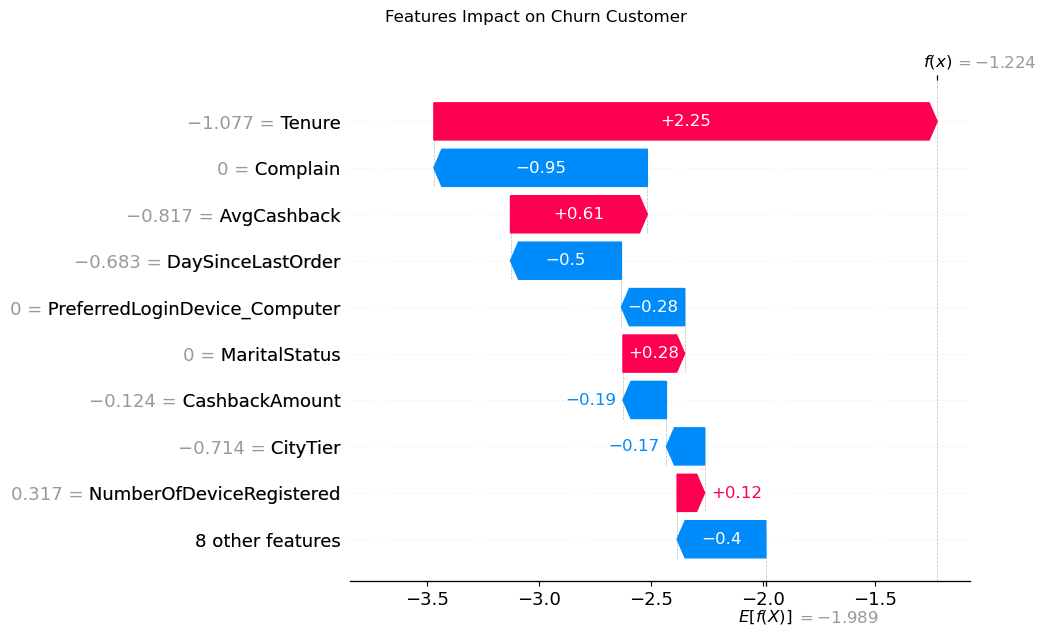

In [45]:
shap.plots.waterfall(shap_values[1], show=False)
plt.title('Features Impact on Churn Customer',x=0.3, y=1.1)
plt.show()